In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score
import pickle
import random, os, json
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, GRU, Dropout, Dense
from tensorflow.keras import backend as K

In [2]:
import sys
sys.path.append("../../../libraries/")
import utils
import MMHDI 

# Functions of the model

In [3]:
def build_model(hyperparameters):  
    
    dynamic_input = tf.keras.layers.Input(shape=(hyperparameters["time_step"], hyperparameters['layers'][0]))
    masked = tf.keras.layers.Masking(mask_value=hyperparameters['mask_value'])(dynamic_input)
    
    _, time_steps, num_inputs = masked.get_shape().as_list()

    # Calculation of the scores
    mlp_outputs, static_gate = MMHDI.gated_residual_network(masked,
                                                            hyperparameters['layers'][0],
                                                            output_size=num_inputs,
                                                            dropout_rate=hyperparameters['dropout_rate'],
                                                            use_time_distributed=True,
                                                            additional_context=None,
                                                            return_gate=True)
    
    sparse_weights = tf.keras.layers.Activation('softmax', name="softmax_dyn")(mlp_outputs)
    
    # Score multiplication
    combined = tf.keras.layers.Multiply()([sparse_weights, masked])
    
    gru_encoder = tf.keras.layers.GRU(
        hyperparameters['layers'][1],
        dropout=hyperparameters['dropout_rate'],
        return_sequences=False,
        activation='tanh',
        use_bias=True
    )(combined)
    
    output = tf.keras.layers.Dense(1, activation="sigmoid")(gru_encoder)

    model = tf.keras.Model(dynamic_input, [output])
    myOptimizer = tf.keras.optimizers.Adam(learning_rate=hyperparameters['lr_scheduler'])
    customized_loss = utils.weighted_binary_crossentropy(hyperparameters)
    model.compile(loss=customized_loss, optimizer=myOptimizer)
    
    return model, dynamic_input, sparse_weights

In [4]:
def run_network(X_train, X_val, y_train, y_val, hyperparameters, seed):
    epochs = hyperparameters['epochs']
    batch_size = hyperparameters['batch_size']

    model = None
    model, dynamic_input, sparse_weights = build_model(hyperparameters)
    earlystopping = None
    try:
        earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      min_delta=hyperparameters["mindelta"],
                                                      patience=hyperparameters["patience"],
                                                      restore_best_weights=True,
                                                      mode="min")
        hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                         callbacks=[earlystopping], batch_size=batch_size, epochs=epochs,
                         verbose=hyperparameters['verbose'])
        
        return model, dynamic_input, sparse_weights, hist, earlystopping
    except KeyboardInterrupt:
        print ('Training duration (s) : ', time.time() - global_start_time)
        return model, y_test, 0, 0


In [5]:
def myCVGrid(hyperparameters, dropout_rate, lr_sch, layers, split, seed):
    bestHyperparameters = {}
    bestMetricDev = np.inf

    for k in range(len(dropout_rate)):
        for l in range(len(layers)):
            for m in range(len(lr_sch)):
                hyperparameters_copy = hyperparameters.copy()
                hyperparameters_copy['dropout_rate'] = dropout_rate[k]
                hyperparameters_copy['layers'] = layers[l]
                hyperparameters_copy['lr_scheduler'] = lr_sch[m]
            
                
                v_early = []
                v_metric_dev = []
                v_hist = []
                v_val_loss = []
               
                for n in range(5):
                    #Load train and validation 
                    X_train = np.load("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(i) +
                                          "/X_train_tensor_" + str(n)+ ".npy")
                    y_train = pd.read_csv("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(i) +
                                          "/y_train_" + str(n)+ ".csv",
                                         index_col=0)

                    X_val = np.load("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(i) +
                                        "/X_val_tensor_" + str(n)+ ".npy")
                    y_val = pd.read_csv("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(i) +
                                        "/y_val_" + str(n)+ ".csv",
                                       index_col=0)

                    # Reset keras
                    utils.reset_keras()
                    
                    # Train the network
                    model, dynamic_input, sparse_weights, hist, early = run_network(X_train, X_val,
                                                                                    y_train.individualMRGerm.values, 
                                                                                    y_val.individualMRGerm.values,
                                                                                    hyperparameters_copy,
                                                                                    seed
                                                                                )
                    del model
                    v_early.append(early)
                    v_hist.append(hist)
                    v_val_loss.append(np.min(hist.history["val_loss"]))
                    
                metric_dev = np.mean(v_val_loss)
                if metric_dev < bestMetricDev:
                    bestMetricDev = metric_dev
                    bestHyperparameters = {
                        'dropout_rate': dropout_rate[k],
                        'layers': layers[l],
                        'lr_scheduler': lr_sch[m]
                    }

    return bestHyperparameters, X_train, X_val, y_train, y_val

# Hyperparameters

In [6]:
seeds = [20, 30, 45, 70]
results = ""
debug = True
balance = True
tensor = True

epochs = 10000
batch_size = 128
inputShape = 56
time_step = 14

layers = [[inputShape, 3, 1], [inputShape, 5, 1], [inputShape, 8, 1], [inputShape, 10, 1], 
          [inputShape, 15, 1], [inputShape, 20, 1],  [inputShape, 25, 1], [inputShape, 30, 1], 
          [inputShape, 35, 1], [inputShape, 40, 1], [inputShape, 50, 1]]

lr_scheduler = [0.0001, 0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.1, 0.2, 0.3]

w2 = 0.18
w1 = 0.82

hyperparameters = {
    "epochs":epochs,
    'batch_size': batch_size,
    "w1":w1, "w2":w2, 
    'mask_value':666,
    'monitor': 'val_loss', "mindelta": 0,
    'balance': balance, "time_step": time_step,
    'optimizer':'adam',
    'patience':30,
    'verbose':0,
    'kfold':5,
    'level':3
}

# Code

In [7]:
run_model = False

if run_model:
    v_early = []
    loss_dev = []
    v_models = []
    bestHyperparameters_bySplit = {}
    y_pred_by_split = {}
    weights = []
    
    for i in [1, 2, 3]:
        X_test = np.load("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(i) + "/X_test_tensor.npy")
        y_test = pd.read_csv("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(i) + "/y_test.csv",
                            index_col=0)
        
    
        bestHyperparameters, X_train, X_val, y_train, y_val = myCVGrid(hyperparameters,
                                                                       dropout_rate,
                                                                       lr_scheduler,
                                                                       layers,
                                                                       i,                                                              
                                                                       seeds[i],
                                                                      )
        split_directory = './Results_NLHA/split_' + str(i)
        bestHyperparameters_bySplit[str(i)] = bestHyperparameters
    
        if not os.path.exists(split_directory):
            os.makedirs(split_directory)
    
        with open(os.path.join(split_directory, f"bestHyperparameters_split_{i}.pkl"), 'wb') as f:
            pickle.dump(bestHyperparameters, f)
    
    
        hyperparameters = {
            "w1":hyperparameters["w1"], "w2":hyperparameters["w2"],                                    
            "time_step": hyperparameters["time_step"],
            'epochs':  hyperparameters["epochs"],
            'batch_size': hyperparameters["batch_size"],
            'mask_value': hyperparameters["mask_value"],
            'earlyStopping': True,
            'kfold': hyperparameters["kfold"],
            'monitor': hyperparameters["monitor"],
            "mindelta": hyperparameters["mindelta"],
            "patience": hyperparameters["patience"],
            'balance': hyperparameters["balance"],
            "dropout_rate": bestHyperparameters["dropout_rate"],
            "layers": bestHyperparameters["layers"],
            "lr_scheduler": bestHyperparameters["lr_scheduler"],
            "level": 3, 'verbose': 0
        }
    

        utils.reset_keras()    
        model, dynamic_input, sparse_weights, hist, early = run_network(
            X_train, X_val, 
            y_train, y_val,
            hyperparameters, 
            seeds[i]
        )    
        
        scores_layer = K.function([dynamic_input], [sparse_weights])
        attn_weights = scores_layer([X_test])
        weights.append(attn_weights[0])
        
        with open(os.path.join(split_directory, f"weights_split_{i}.pkl"), 'wb') as f:
            pickle.dump(attn_weights, f)
                    
        v_models.append(model)
        loss_dev.append(hist.history['val_loss'])
    
        y_pred = model.predict(x=[X_test])
        y_pred_by_split[str(i)] = y_pred
        
        with open(os.path.join(split_directory, f"y_pred_split_{i}.pkl"), 'wb') as f:
            pickle.dump(y_pred, f)
    
        # Save model for current split
        model_filename = os.path.join(split_directory, f"model_split_{i}.h5")
        model.save(model_filename)
    
        # Calculate metrics
        metrics_dict = utils.calculate_and_save_metrics(
        y_test.individualMRGerm.values, 
        y_pred, 
        split_directory, 
        split_index=i
        )

# Importance scores

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

keys = [
    'AMG', 'ATF', 'CAR', 'CF1', 'CF2', 'CF3', 'CF4', 'Others', 'GCC', 'GLI', 'LIN', 'LIP', 'MAC',
    'MON', 'NTI',  'OTR', 'OXA', 'PAP', 'PEN', 'POL', 'QUI', 'SUL', 'TTC',
    
    r'$acinet._{pc}$', r'$enterob._{pc}$', r'$enteroc._{pc}$', 
    r'$pseudo._{pc}$', r'$staph._{pc}$', r'$stenot._{pc}$', r'$others_{pc}$',
    
    'Mech. Vent.',

    '# pat.', '# MDR pat.',
    
    r'$AMG_{n}$', r'$ATF_{n}$', r'$CAR_{n}$', r'$CF1_{n}$', r'$CF2_{n}$', r'$CF3_{n}$',
    r'$CF4_{n}$', r'$Others_{n}$', r'$GCC_{n}$', r'$GLI_{n}$', r'$LIN_{n}$', r'$LIP_{n}$', r'$MAC_{n}$',
    r'$MON_{n}$', r'$NTI_{n}$', r'$OTR_{n}$', r'$OXA_{n}$', r'$PAP_{n}$',
    r'$PEN_{n}$', r'$POL_{n}$', r'$QUI_{n}$', r'$SUL_{n}$', r'$TTC_{n}$']

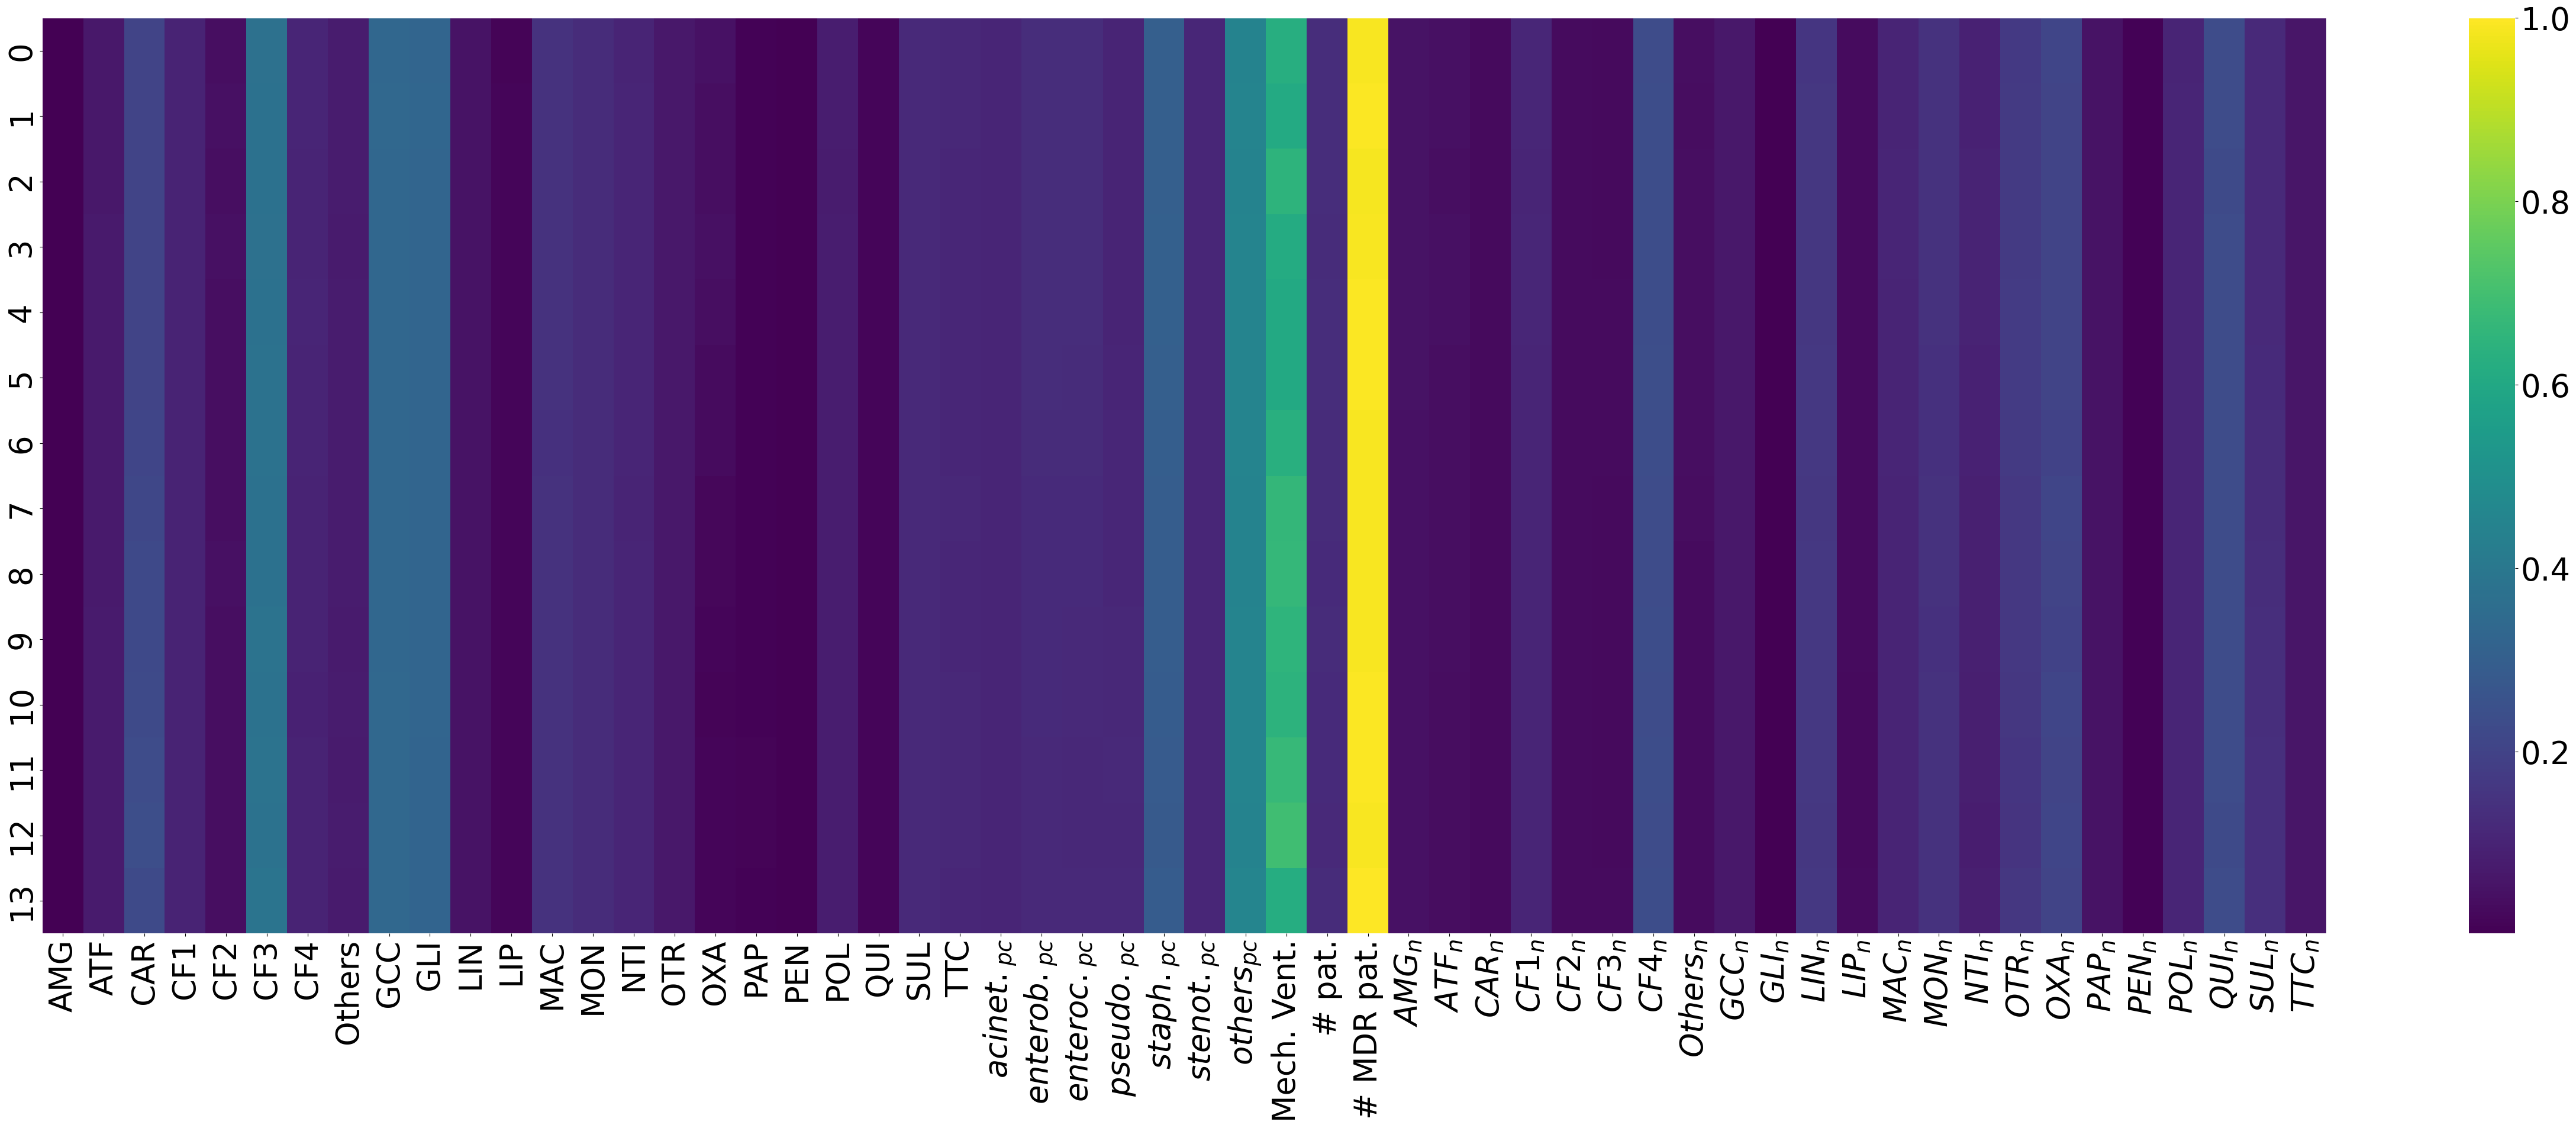

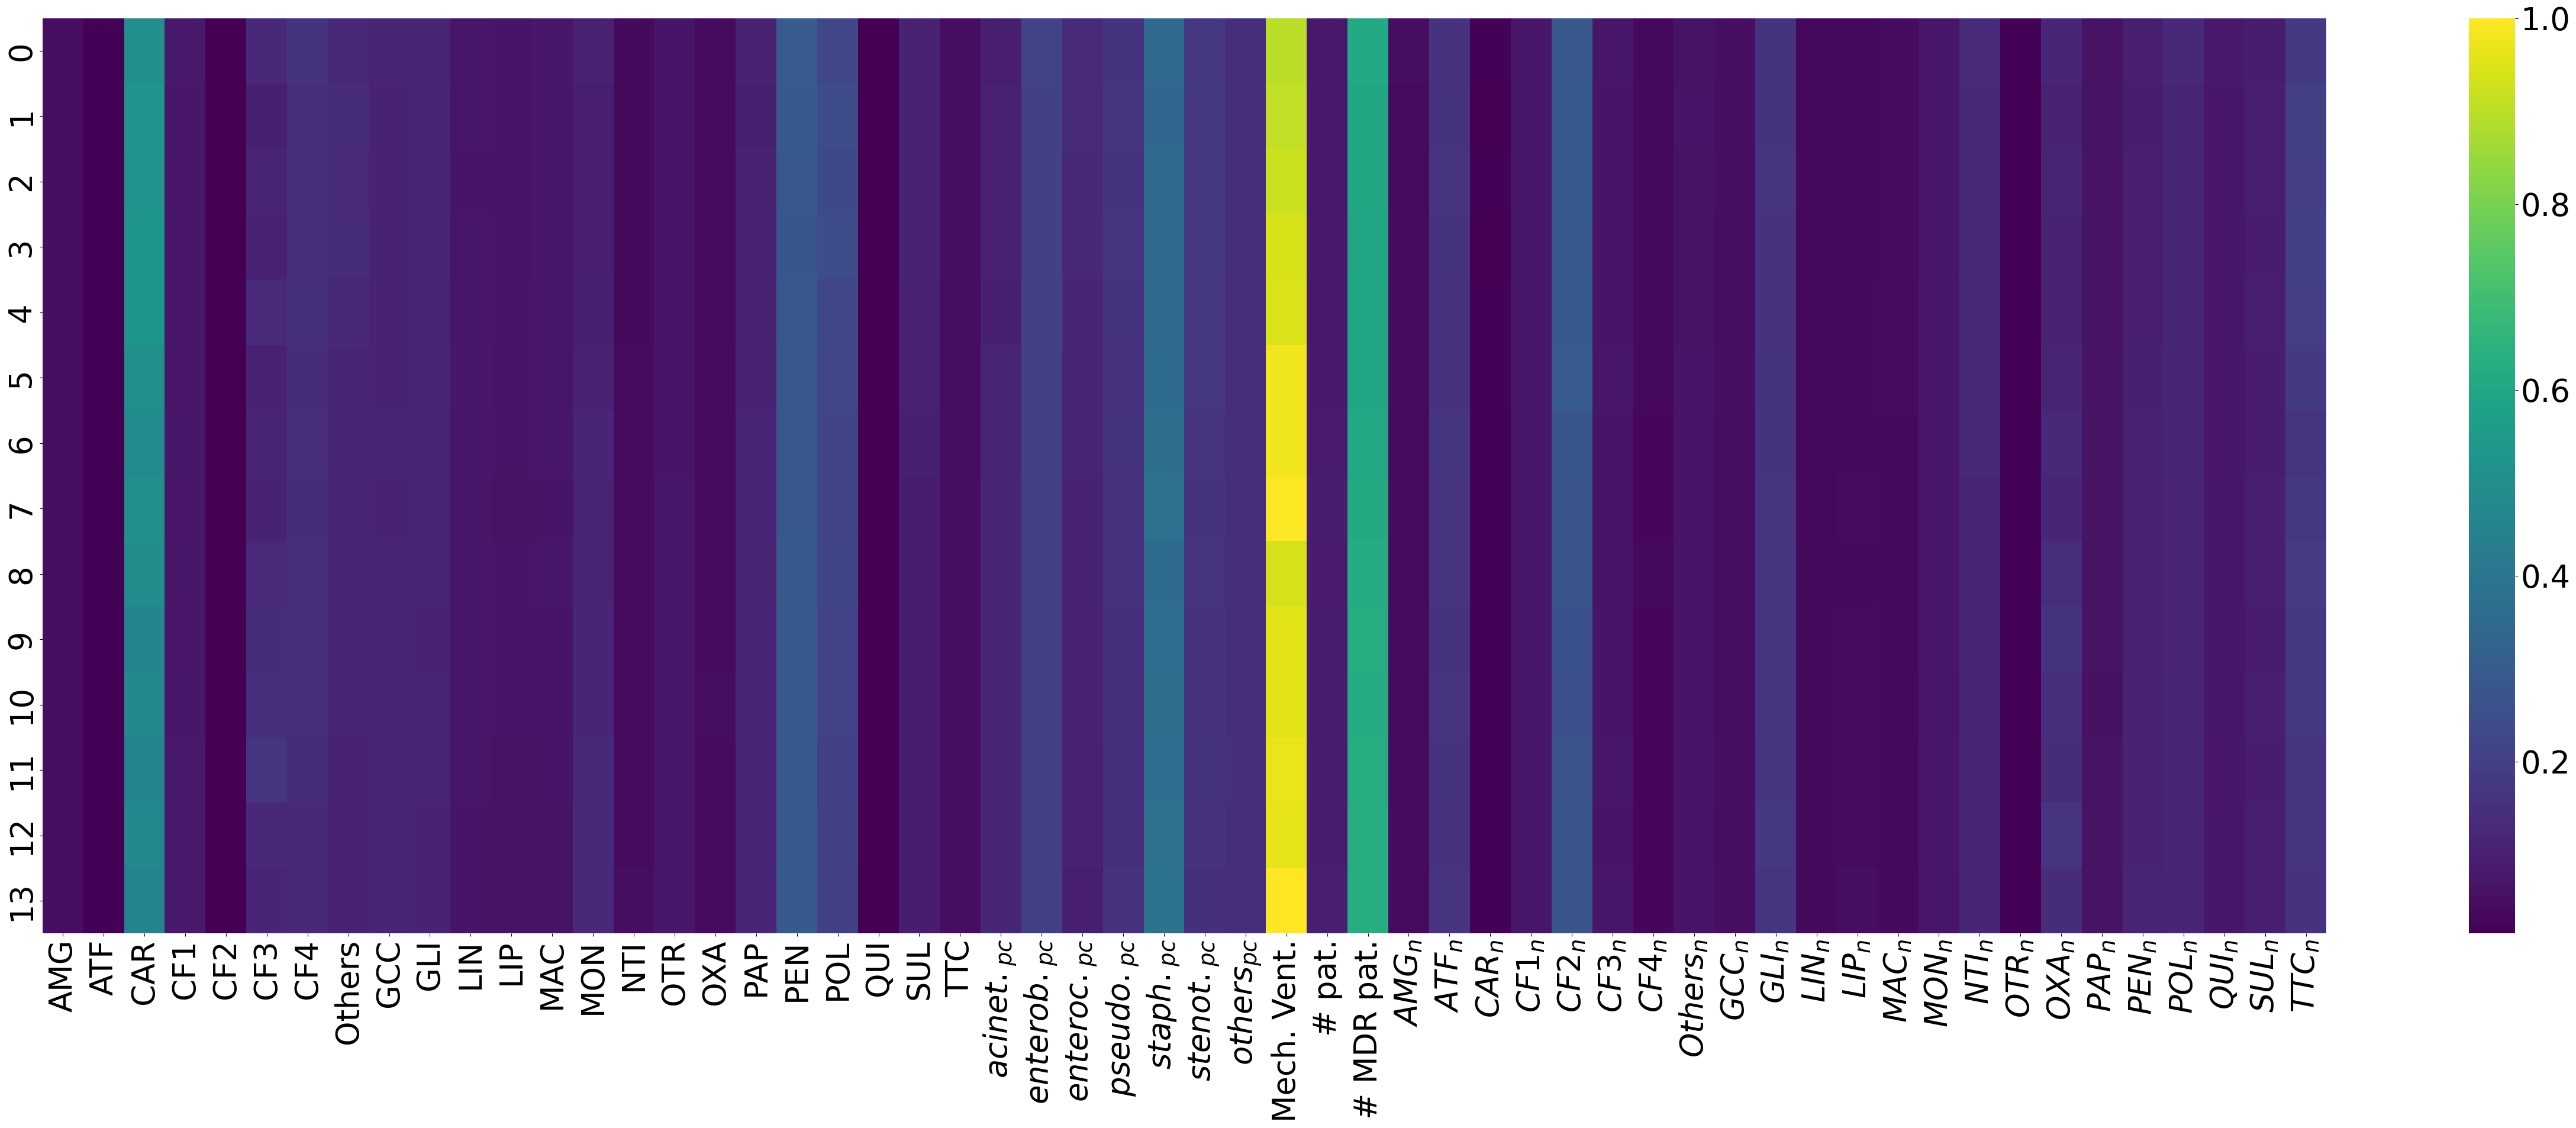

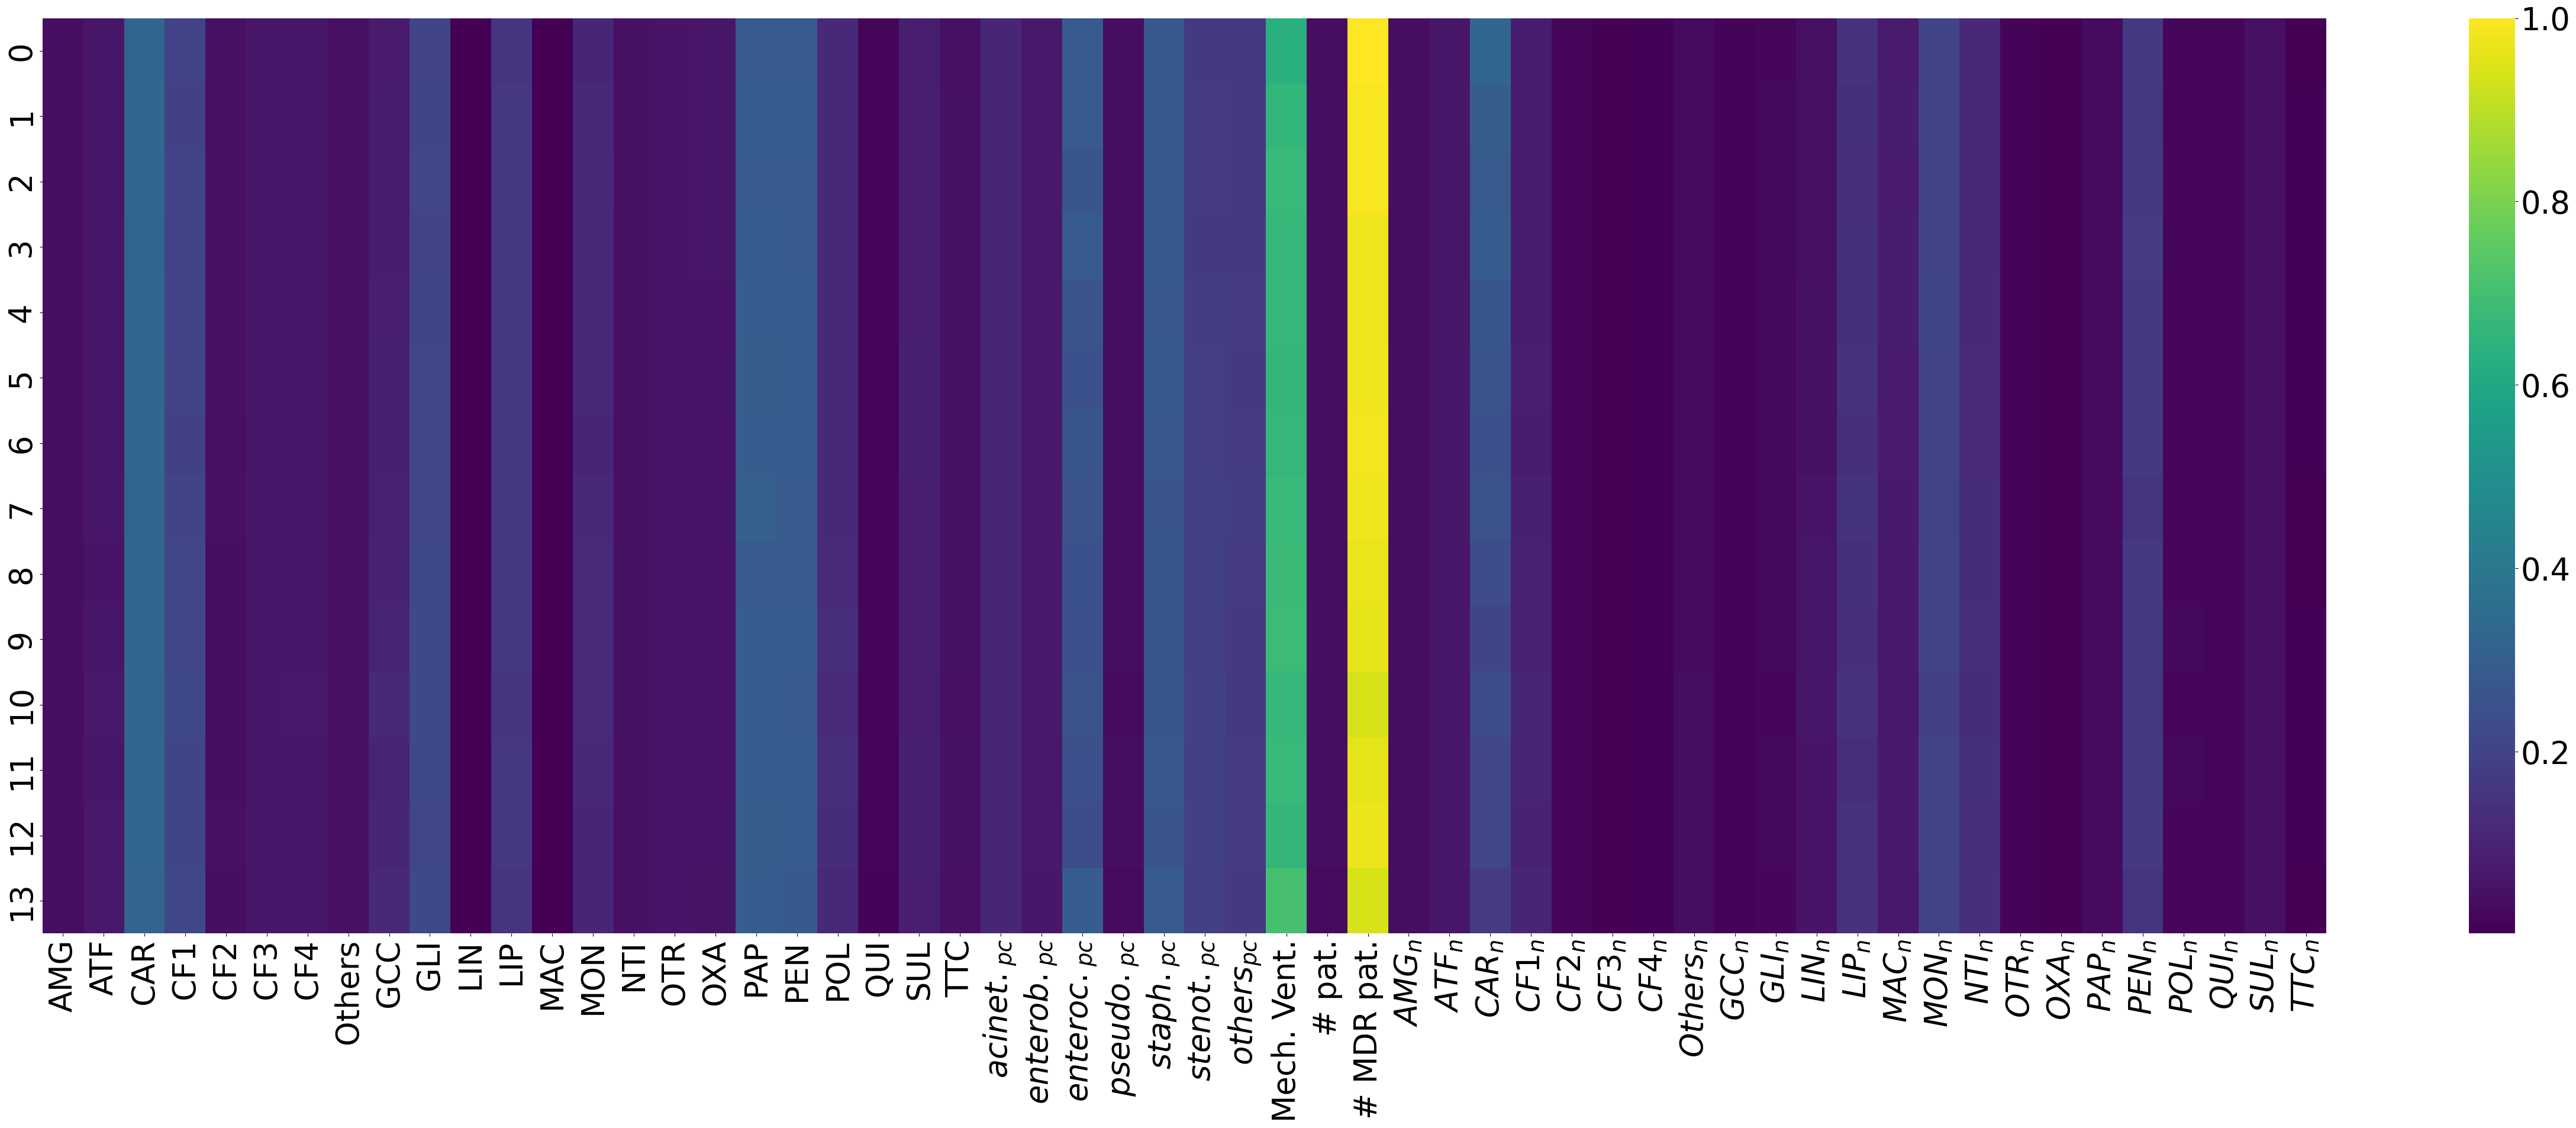

In [9]:
from matplotlib import rcParams
import pickle

def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

for i in [1, 2, 3]:
    v_heatmap = []
    X_test = np.load(f"../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_{i}/X_test_tensor.npy")
    y_test = pd.read_csv(f"../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_{i}/y_test.csv", index_col=0)
    
    weights = load_from_pickle(f"./Results_NLHA/split_{i}/weights_split_{i}.pkl")  
    
    heatmap_att = np.zeros(weights[0].shape)
    
    # Create heatmap for each layer
    for j in range(weights[0].shape[2]):
        heatmap_att[:, :, j] = np.where(X_test[:, :, j] == 666, np.nan, weights[0][:, :, j])

    mean_heatmap = np.nanmean(heatmap_att, axis=0)
    v_heatmap.append(mean_heatmap)

    # Normalize the weights
    mask_weights = v_heatmap[0].copy()
    mask_weights = mask_weights / mask_weights.max()

    rcParams['font.size'] = 38
    
    plt.subplots(figsize=(50, 20))
    heatmap = sns.heatmap(mask_weights, cmap='viridis')
    heatmap.axes.set_xticklabels(keys, rotation=90)
    plt.tight_layout()
    
    plt.savefig(f"./Figures/heatmap_NLHA_s{i}.pdf", bbox_inches='tight')
